In [1]:
# imports
import os
import pandas as pd
import seaborn as sns

## Creating taxonomic table

In [ ]:
# VARIABLES

project = 'Jamy_2022'
cell = 'cell'
marker = 'rDNA'
sim = 'sim97'
raw_data = '../raw_data'
tax_assign_results =  f'{raw_data}/tax_assign_results/{project}/{marker}/{cell}/{sim}'
otu_results = f'{raw_data}/OTU_results/{project}'

In [ ]:
# get paths

files = os.listdir(tax_assign_results)
paths = [tax_assign_results + '/' + file for file in files]

record = {'otu_id': [], 
          'abundance': [],
          'kingdom': [], 
          'domain': [], 
          'phyllum': [], 
          'class': [], 
          'order': [], 
          'family': [], 
          'genus': [], 
          'species': [], 
          'closest_match': [],
          'percent_identity': [], 
          'sample': []}
    
for path in paths:
    with open(path, 'rt') as f:
        lines = f.readlines()
        for line in lines:
            record['otu_id'].append(line.split('\t')[0])
            record['abundance'].append(line.split('\t')[0].split('=')[-1])
            tax_assign = line.split('\t')[1]
            record['kingdom'].append(tax_assign.split(',')[0].split(':')[1])
            record['domain'].append(tax_assign.split(',')[1].lstrip('d:'))
            record['phyllum'].append(tax_assign.split(',')[2].lstrip('p:'))
            record['class'].append(tax_assign.split(',')[3].lstrip('c:'))
            record['order'].append(tax_assign.split(',')[4].lstrip('o:'))
            record['family'].append(tax_assign.split(',')[5].lstrip('f:'))
            record['genus'].append(tax_assign.split(',')[6].lstrip('g:'))
            record['species'].append(tax_assign.split(',')[7].lstrip('s:'))
            record['closest_match'].append(line.split('\t')[1].split(';')[0].split('.')[0])
            record['percent_identity'].append(line.split('\t')[2])
            record['sample'].append(path.split('/')[-1].lstrip('blast6_').rstrip('.tab'))

        
sum_table = pd.DataFrame.from_dict(record)

In [ ]:
# removing the '_21R' from all the sample names if present (this applied for Suthaus 2022 rDNA data)
sum_table['sample'] = sum_table['sample'].str.replace('_21R','')

In [ ]:
sum_table_filtered = sum_table[sum_table['abundance'] != '1']

In [ ]:
# save the summary table as excel tables

sum_table.to_excel(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx')

In [ ]:
# save the summary table as tsv tables

sum_table.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.tsv', sep = '\t')

In [ ]:
# save the filtered summary table as tsv tables

sum_table_filtered.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}_filtered.tsv', sep = '\t')

## Creating final taxonomic table

In [2]:
# VARIABLES

project = 'Suthaus_2022'
cell = 'cellCombined'
marker = 'Full18S'
sim = 'sim90'
denoise_method = 'RAD'
raw_data = os.path.join('..', 'raw_data')
tax_assign_results = os.path.join(raw_data, 'tax_assign_results', project, marker, cell, sim, denoise_method)
otu_results = os.path.join(raw_data, 'OTU_results', project)

In [3]:
# Samples
!ls $tax_assign_results

blast6_A3_18S.tab    blast6_Sim17_18S.tab  blast6_Th40_18S.tab
blast6_Mock_18S.tab  blast6_Sim22_18S.tab  blast6_X17007_18S.tab
blast6_NH1_18S.tab   blast6_Th16_18S.tab
blast6_NH4_18S.tab   blast6_Th38_18S.tab


### DataFrame

Read all the files from the tax_assign_results directory and concatenate them into a single DataFrame

In [4]:
# 1. List all files in the directory
files = [f for f in os.listdir(tax_assign_results) if f.endswith('.tab')]

# 2. Iterate over each file
dfs = []

for f in files:
    # extract sample name
    sample_name = f.split('_')[1]
    # Load file into DataFrame
    df = pd.read_csv(f'{tax_assign_results}/{f}', sep='\t', header=None)
    # Add a new column for sample name
    df['Sample'] = sample_name
    dfs.append(df)

# 3. Concatenate all DataFrames
all_samples = pd.concat(dfs, ignore_index=True)

In [5]:
## 4. Dataframe adjustments

# Replace 'centroid=' with an empty string in the first column
all_samples[all_samples.columns[0]] = all_samples[all_samples.columns[0]].str.replace('centroid=', '', regex=False)
# Split the first column based on the ';' delimiter
all_samples[['OTU', 'OTU_Num']] = all_samples[all_samples.columns[0]].str.split(';', expand = True)
# Extract only the number from the 'OTU_Num' column (after 'seqs=')
all_samples['OTU_Num'] = all_samples['OTU_Num'].str.split('=').str[1].astype(int)
# Drop the original column
all_samples = all_samples.drop(columns=all_samples.columns[0])
# Create a reference ID column
all_samples['Reference_ID'] = all_samples[1].str.split(';').str[0]
# Creating a Kingdom columm
all_samples['Kingdom'] = all_samples[1].str.split(':').str[1].str.split(',').str[0]
# Creating a Domain columm
all_samples['Domain'] = all_samples[1].str.split(':').str[2].str.split(',').str[0]
# Creating a Phyllum columm
all_samples['Phyllum'] = all_samples[1].str.split(':').str[3].str.split(',').str[0]
# Creating a Class columm
all_samples['Class'] = all_samples[1].str.split(':').str[4].str.split(',').str[0]
# Creating an Order columm
all_samples['Order'] = all_samples[1].str.split(':').str[5].str.split(',').str[0]
# Creating a Family columm
all_samples['Family'] = all_samples[1].str.split(':').str[6].str.split(',').str[0]
# Creating a Genus columm
all_samples['Genus'] = all_samples[1].str.split(':').str[7].str.split(',').str[0]
# Creating a Species columm
all_samples['Species'] = all_samples[1].str.split(':').str[8].str.split(',').str[0]
# Dropping the original column
all_samples = all_samples.drop(columns=all_samples.columns[0])
# Creating a pident (percentage of identical positions) column
all_samples['Pident'] = all_samples[2]
# Creating a length (alignment length (sequence overlap)) column
all_samples['Length'] = all_samples[3]
# Drop unnecessary columns
all_samples = all_samples.drop(all_samples.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1)
# Rearrange the columns
cols = [col for col in all_samples if col != 'Sample'] + ['Sample']
all_samples = all_samples[cols]

In [6]:
all_samples

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
0,seq106_27,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,94.5,683,Th38
1,seq150_65,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,95.1,884,Th38
2,seq104_29,6,DQ462456.1.1771_U,Eukaryota,Alveolata,Apicomplexa,Gregarinomorphea,Neogregarinorida,Actinocephalidae,Ascogregarina,Ascogregarina_culicis,84.0,1748,Th38
3,seq213_14,1,KC511080,Eukaryota,Rhizaria,Cercozoa,Endomyxa,Vampyrellida,Leptophryidae,Leptophryidae_X,Leptophryidae_XX,92.2,641,Th38
4,seq222_12,1,EF165122.1.1785_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeE,Chrysophyceae_CladeE_X,Chrysophyceae_CladeE_X_sp.,91.0,662,Th38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,seq85_97,1,JQ031960.1.6974_G,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,StemonitalesPhysarales_X,Colloderma,Colloderma_robustum,94.9,723,NH1
847,seq4_578,4,GQ410641.1.1895_U,Eukaryota,Opisthokonta,Metazoa,Arthropoda,Hexapoda,Insecta,Platygaster,Platygaster_sp.,94.0,1951,NH1
848,seq73_19,2,AB013175.1.3767_U,Eukaryota,Archaeplastida,Rhodophyta,Bangiophyceae,Bangiales,Bangiaceae,Pyropia,Pyropia_tenera,84.4,1777,NH1
849,seq72_22,1,HE614616.1.7859_U,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,Didymiaceae,Diderma,Diderma_niveum,92.2,1236,NH1


In [12]:
all_samples.sort_values('Pident').head(20)

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
673,seq64_18,1,KC990933.1.2057_U,Eukaryota,Excavata,Discoba,Euglenida,Euglenida_X,Ploeotiidae,Olkasia,Olkasia_polycarbonata,70.6,2091,X17007
296,seq29_39,4,KJ762758.1.2063_U,Eukaryota,Excavata,Discoba,Diplonemea,Diplonemida,Eupelagonemidae,Eupelagonemidae_X,Eupelagonemidae_X_sp.,71.6,2075,A3
294,seq293_25,1,AY425009.1.2062_U,Eukaryota,Excavata,Discoba,Diplonemea,Diplonemida,Diplonemidae,Diplonema,Diplonema_ambulator,71.7,2101,A3
214,seq102_34,1,KC990933.1.2057_U,Eukaryota,Excavata,Discoba,Euglenida,Euglenida_X,Ploeotiidae,Olkasia,Olkasia_polycarbonata,71.8,2120,A3
651,seq223_11,1,KC990933.1.2057_U,Eukaryota,Excavata,Discoba,Euglenida,Euglenida_X,Ploeotiidae,Olkasia,Olkasia_polycarbonata,72.2,2099,X17007
461,seq252_22,7,AF129882.1.1682_U,Eukaryota,Alveolata,Apicomplexa,Gregarinomorphea,Eugregarinorida,Gregarinidae,Gregarina1,Gregarina1_niphandrodes,73.2,1641,Sim17
195,seq395_6,1,AY490211.1.1995_U,Eukaryota,Excavata,Discoba,Diplonemea,Diplonemida,Diplonemidae,Rhynchopus,Rhynchopus_sp.,73.5,2101,Sim22
303,seq302_14,1,AY753948.1.2001_U,Eukaryota,Excavata,Discoba,Kinetoplastea,Prokinetoplastida,Ichthyobodonidae,Ichthyobodonidae_X,Ichthyobodonidae_X_sp.,73.6,2031,A3
518,seq437_6,1,AF274257.1.1756_U,Eukaryota,Alveolata,Dinoflagellata,Dinophyceae,Peridiniales,Peridiniales_X,Glenodiniopsis,Glenodiniopsis_uliginosa,73.8,1205,Sim17
635,seq199_6,1,MF422192.1.2021_U,Eukaryota,Excavata,Discoba,Diplonemea,Diplonemida,Diplonemidae,Diplonema,Diplonema_aggregatum,73.9,2080,X17007


In [116]:
# Save the DataFrame to CSV
output_filename = f'final_tax_table_{marker}_{sim}.csv'
output_path = os.path.join(otu_results, output_filename)

all_samples.to_csv(output_path, index=False)

## Preparing the Data for Plotting and Plotting

In [207]:
# Functions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_data_for_plotting(dataframe, taxonomic_level, threshold_percentage=5, grouping='unique_otus'):
    '''
    Prepare data for taxonomic composition plotting.
    
    Parameters:
    - filtered_samples (pd.DataFrame): The filtered data containing taxonomic information.
    - taxonomic_level (str): The taxonomic level for the analysis (e.g., "Domain", "Phylum").
    - threshold_percentage (int, optional): The threshold below which taxa are grouped into 'Others'. Default is 5%.
    - grouping (str, optional): How to group the data. Options: 'unique_otus' or 'abundances'. Default is 'unique_otus'.
    
    Returns:
    - pivot_table (pd.DataFrame): The modified pivot table for plotting.
    - excluded_columns (list): A list of columns to be excluded from the legend.
    '''
    
    
    # Filter out the 'Mock' sample and 'Bacteria_X' domain
    filtered_samples = dataframe[(dataframe['Sample'] != 'Mock') & (dataframe[taxonomic_level] != 'Bacteria_X')]
    
    # Pivot table to get counts of sequences for each domain per sample
    if grouping == 'abundances':
        pivot_table = filtered_samples.groupby(['Sample', taxonomic_level])['OTU_Num'].sum().unstack(fill_value=0)
    elif grouping == 'unique_otus':
        pivot_table = filtered_samples.groupby(['Sample', taxonomic_level])['OTU'].nunique().unstack(fill_value=0)
    else:
        raise ValueError("Invalid value for 'grouping'. Choose 'unique_otus' or 'abundances'.")
    
    # Calculate proportions within each sample
    proportions = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100

    # Determine which entries fall below the threshold
    small_entries = proportions < threshold_percentage

    # Create 'Others' column
    pivot_table['Others'] = 0

    for sample in pivot_table.index:
        # Mask for the current sample's small entries
        mask = small_entries.loc[sample]
        
        # Sum up small groups into 'Others' for the current sample
        pivot_table.at[sample, 'Others'] = pivot_table.loc[sample, mask.index[mask]].sum()
        
        # Zero out the original small group values for the current sample
        pivot_table.loc[sample, mask.index[mask]] = 0

    # Rename the 'Others' column to include the threshold percentage
    others_label = f'Others (Taxa below {threshold_percentage}%)'
    pivot_table.rename(columns={'Others': others_label}, inplace=True)

    # Identify columns to exclude from the legend
    excluded_columns = small_entries.all(axis=0)  # Find taxa that are consistently "small" across all samples
    excluded_columns = excluded_columns[excluded_columns].index.tolist()

    return pivot_table, excluded_columns

def plot_taxonomic_data(pivot_table, excluded_columns, taxonomic_level, grouping):
    '''
    Plot the taxonomic composition per sample based on the provided pivot table.
    
    Parameters:
    - pivot_table (pd.DataFrame): The pivot table containing the data to be plotted.
    - excluded_columns (list): A list of columns to be excluded from the legend.
    - taxonomic_level (str): The taxonomic level for the analysis (e.g., "Domain", "Phylum").
    - grouping (str): How to group the data. Options: 'unique_otus' or 'abundances'.
    
    Returns:
    - None
    '''
    # Define the color palette
    colors = sns.color_palette('husl', len(pivot_table.columns) - len(excluded_columns))

    # Plotting
    ax = pivot_table.drop(columns=excluded_columns).plot(kind='bar', stacked=True, figsize=(10,7), color=colors)
    plt.title(f'Taxonomic Composition Per Sample at {taxonomic_level} Level')
    if grouping == 'abundances':
        plt.ylabel('OTU abundance')
    else:
        plt.ylabel('Total Number of unique OTUs')
    
    plt.xlabel('Sample')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()



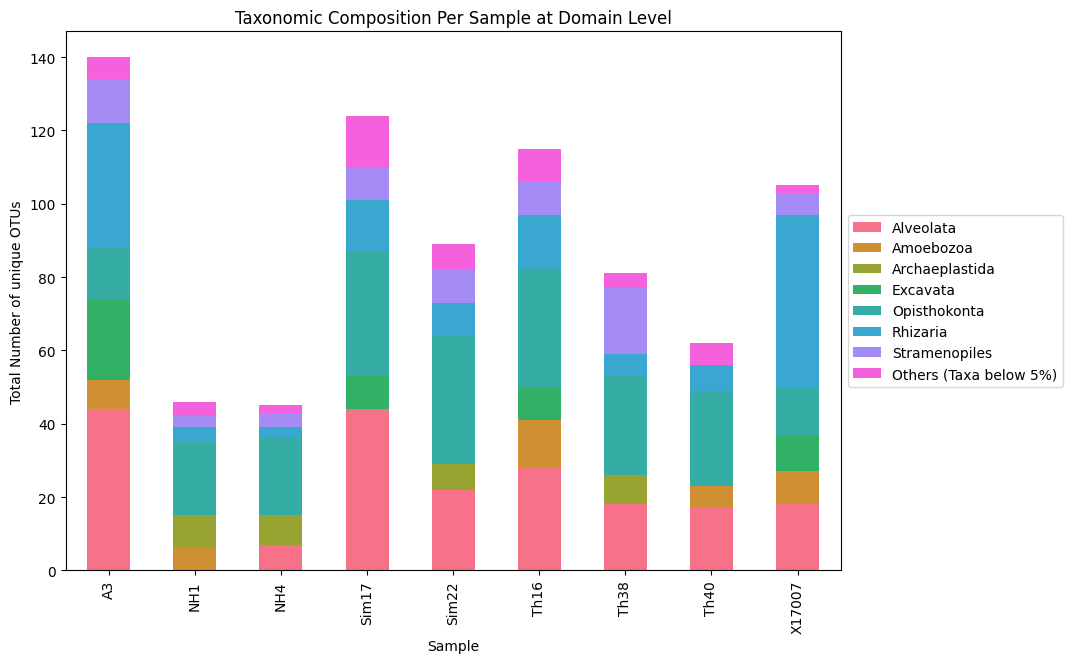

In [209]:
# Plotting data
# Filter out the 'Mock' sample and 'Bacteria_X' domain
filtered_samples = all_samples[(all_samples['Sample'] != 'Mock') & (all_samples[taxonomic_level] != 'Bacteria_X')]
pivot_table, excluded_columns = prepare_data_for_plotting(filtered_samples, taxonomic_level='Domain', threshold_percentage=5, grouping='unique_otus')
plot_taxonomic_data(pivot_table, excluded_columns, taxonomic_level='Domain', grouping='unique_otus')

In [ ]:
# TODO: transfer the functions into a separate py file
# TODO: make a save function
# TODO: create plots